# Imports


In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

import functools
import operator
from functools import partial
import logging
import pathlib
from pathlib import Path
from pprint import pprint
import sys
from typing import *
import time
import yaml
from yaml import YAMLObject

import humanize
from matplotlib import pyplot as plt, cm
import numpy as np
import pandas as pd
from pymicro.file import file_utils
import tensorflow as tf
from numpy.random import RandomState

from tensorflow import keras
from tensorflow.keras import utils
from tensorflow.keras import optimizers
from tensorflow.keras import callbacks as keras_callbacks
from tensorflow.keras import losses
from tensorflow.keras import metrics as keras_metrics

from tomo2seg import slack
from tomo2seg import modular_unet
from tomo2seg.logger import logger
from tomo2seg import data, viz
from tomo2seg.data import Volume
from tomo2seg.metadata import Metadata
from tomo2seg.volume_sequence import (
    MetaCrop3DGenerator, VolumeCropSequence,
    UniformGridPosition, SequentialGridPosition,
    ET3DUniformCuboidAlmostEverywhere, ET3DConstantEverywhere, 
    GTUniformEverywhere, GTConstantEverywhere, 
    VSConstantEverywhere, VSUniformEverywhere
)
from tomo2seg import volume_sequence
from tomo2seg.model import Model as Tomo2SegModel
from tomo2seg import callbacks as tomo2seg_callbacks
from tomo2seg import losses as tomo2seg_losses
from tomo2seg import schedule as tomo2seg_schedule
from tomo2seg import utils as tomo2seg_utils


# Setup


In [3]:
logger.setLevel(logging.DEBUG)

In [4]:
random_state = 42
random_state = np.random.RandomState(random_state)
runid = int(time.time())
# runid = 1606238421
logger.info(f"{runid=}")

INFO::tomo2seg::{<ipython-input-4-f5dd942bd525>:<module>:005}::[2020-12-09::18:09:25.451]
runid=1607533765



In [5]:
n_gpus = len(tf.config.list_physical_devices('GPU'))
    
logger.debug(f"{tf.__version__=}")
logger.info(f"Num GPUs Available: {n_gpus}\nThis should be 2 on R790-TOMO.")
logger.debug(f"Should return 2 devices...\n{tf.config.list_physical_devices('GPU')=}")
logger.debug(f"Should return 2 devices...\n{tf.config.list_logical_devices('GPU')=}")

# xla auto-clustering optimization (see: https://www.tensorflow.org/xla#auto-clustering)
# this seems to break the training
tf.config.optimizer.set_jit(False)

# get a distribution strategy to use both gpus (see https://www.tensorflow.org/guide/distributed_training)
strategy = tf.distribute.MirroredStrategy()  

DEBUG::tomo2seg::{<ipython-input-5-3220786131f1>:<module>:003}::[2020-12-09::18:09:25.519]
tf.__version__='2.2.0'

INFO::tomo2seg::{<ipython-input-5-3220786131f1>:<module>:004}::[2020-12-09::18:09:25.520]
Num GPUs Available: 1
This should be 2 on R790-TOMO.

DEBUG::tomo2seg::{<ipython-input-5-3220786131f1>:<module>:005}::[2020-12-09::18:09:25.521]
Should return 2 devices...
tf.config.list_physical_devices('GPU')=[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

DEBUG::tomo2seg::{<ipython-input-5-3220786131f1>:<module>:006}::[2020-12-09::18:09:25.619]
Should return 2 devices...
tf.config.list_logical_devices('GPU')=[LogicalDevice(name='/device:GPU:0', device_type='GPU')]

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


# Args

In [8]:
MULTIPLE_REQUIREMENT = 16
logger.info(f"{MULTIPLE_REQUIREMENT=}")

# these are estimates based on things i've seen fit in the GPU
MAX_INTERNAL_NVOXELS = max(
    # seen cases
    4 * (8 * 6) * (96**3),
    8 * (16 * 6) * (320**2),  
    3 * (16 * 6) * (800 * 928),
)

MAX_INTERNAL_NVOXELS *= 5/8  # a smaller gpu on other pcs...

logger.info(f"{MAX_INTERNAL_NVOXELS=} ({humanize.intcomma(MAX_INTERNAL_NVOXELS)})")

# override_batch_size = None
# doing this to reproduce the same conditions...
override_batch_size_per_gpu = 8

INFO::tomo2seg::{<ipython-input-8-47a20a733e5b>:<module>:002}::[2020-12-09::18:09:51.733]
MULTIPLE_REQUIREMENT=16

INFO::tomo2seg::{<ipython-input-8-47a20a733e5b>:<module>:014}::[2020-12-09::18:09:51.735]
MAX_INTERNAL_NVOXELS=133632000.0 (133,632,000.0)



# Data

In [10]:
from tomo2seg.datasets import (
    VOLUME_COMPOSITE_V1 as VOLUME_NAME_VERSION,
#     VOLUME_COMPOSITE_V1_REDUCED as VOLUME_NAME_VERSION,
    VOLUME_COMPOSITE_V1_LABELS_REFINED3 as LABELS_VERSION
)

volume_name, volume_version = VOLUME_NAME_VERSION
labels_version = LABELS_VERSION

logger.info(f"{volume_name=}")
logger.info(f"{volume_version=}")
logger.info(f"{labels_version=}")

INFO::tomo2seg::{<ipython-input-10-cd76321aa4c8>:<module>:010}::[2020-12-09::18:10:08.241]
volume_name='PA66GF30'

INFO::tomo2seg::{<ipython-input-10-cd76321aa4c8>:<module>:011}::[2020-12-09::18:10:08.243]
volume_version='v1'

INFO::tomo2seg::{<ipython-input-10-cd76321aa4c8>:<module>:012}::[2020-12-09::18:10:08.244]
labels_version='refined3'



In [11]:
# Metadata/paths objects

## Volume
volume = Volume.with_check(
    name=volume_name, version=volume_version
)
logger.info(f"{volume=}")

n_classes = len(volume.metadata.labels)

def _read_raw(path_: Path, volume_: Volume): 
    # from pymicro
    return file_utils.HST_read(
        str(path_),  # it doesn't accept paths...
        # pre-loaded kwargs
        autoparse_filename=False,  # the file names are not properly formatted
        data_type=volume.metadata.dtype,
        dims=volume.metadata.dimensions,
        verbose=True,
    )

read_raw = partial(_read_raw, volume_=volume)

logger.info("Loading data from disk.")

## Data
voldata = read_raw(volume.data_path) / 255  # normalize
logger.debug(f"{voldata.shape=}")

voldata_train = volume.train_partition.get_volume_partition(voldata)
voldata_val = volume.val_partition.get_volume_partition(voldata)

logger.debug(f"{voldata_train.shape=}")
logger.debug(f"{voldata_val.shape=}")

del voldata

## Labels
vollabels = read_raw(volume.versioned_labels_path(labels_version))
logger.debug(f"{vollabels.shape=}")

vollabels_train = volume.train_partition.get_volume_partition(vollabels)
vollabels_val = volume.val_partition.get_volume_partition(vollabels)

logger.debug(f"{vollabels_train.shape=}")
logger.debug(f"{vollabels_val.shape=}")

del vollabels

DEBUG::tomo2seg::{data.py:with_check:258}::[2020-12-09::18:10:10.565]
vol=Volume(name='PA66GF30', version='v1', _metadata=None)

DEBUG::tomo2seg::{data.py:metadata:195}::[2020-12-09::18:10:10.573]
Loading metadata from `/home/users/jcasagrande/projects/tomo2seg/data/PA66GF30.v1/PA66GF30.v1.metadata.yml`.

INFO::tomo2seg::{<ipython-input-11-6e0649e4ec97>:<module>:007}::[2020-12-09::18:10:10.587]
volume=Volume(name='PA66GF30', version='v1', _metadata=Volume.Metadata(dimensions=[1300, 1040, 1900], dtype='uint8', labels=[0, 1, 2], labels_names={0: 'matrix', 1: 'fiber', 2: 'porosity'}, set_partitions={'train': {'x_range': [0, 1300], 'y_range': [0, 1040], 'z_range': [0, 1300], 'alias': 'train'}, 'val': {'x_range': [0, 1300], 'y_range': [0, 1040], 'z_range': [1600, 1900], 'alias': 'val'}, 'test': {'x_range': [0, 1300], 'y_range': [0, 1040], 'z_range': [1300, 1600], 'alias': 'test'}}))

INFO::tomo2seg::{<ipython-input-11-6e0649e4ec97>:<module>:024}::[2020-12-09::18:10:10.589]
Loading data from

# Model

In [12]:
try:
    tomo2seg_model
except NameError:
    print("already deleted (:")
else:
    del tomo2seg_model

already deleted (:


In [13]:
# crop_shape = (256, 256, 1)  # multiple of 16 (requirement of a 4-level u-net)
# bigger crops will have less border effects (?)
crop_shape = (112, 112, 1)  # multiple of 16 (requirement of a 4-level u-net)

model_master_name = "unet2d"
model_version = "crop112-f16"
model_factory_function = modular_unet.u_net

model_is_2halfd = False
model_is_2d = True

model_factory_kwargs = {
    **modular_unet.kwargs_vanilla03,
    **dict(
        convlayer=modular_unet.ConvLayer.conv2d,
        input_shape = crop_shape,
        output_channels=n_classes,
#         nb_filters_0 = 2,
#         nb_filters_0 = 4,
#         nb_filters_0 = 8,
#         nb_filters_0 = 12,
        nb_filters_0 = 16,
#         nb_filters_0 = 32,
    ),
}

In [15]:
try:
    tomo2seg_model
    
except NameError:
    logger.info("Creating a Tomo2SegModel.")
    
    tomo2seg_model = Tomo2SegModel(
        model_master_name, 
        model_version, 
        runid=runid,
        factory_function=model_factory_function,
        factory_kwargs=model_factory_kwargs,
    )
                
else:
    logger.warning("The model is already defined. To create a new one: `del tomo2seg_model`")

finally:
    
    logger.info(f"{tomo2seg_model=}")
    
logger.info("Creating the Keras model.")

with strategy.scope():
    if not tomo2seg_model.autosaved_model_path.exists():
        logger.info(f"Instantiating a new model with model_factory_function={model_factory_function.__name__}")
      
        model = model_factory_function(
            name=tomo2seg_model.name,
            **model_factory_kwargs
        )
    else:
        logger.warning("An autosaved model already exists, loading it instead of creating a new one!")
        model = keras.models.load_model(tomo2seg_model.autosaved_model_path_str, compile=False)

    logger.info("Compiling the model.")

    # using the avg jaccard is dangerous if one of the classes is too
    # underrepresented because it's jaccard will be unstable
    loss = tomo2seg_losses.jaccard2_flat

    optimizer = optimizers.Adam(lr=.003)
    metrics = [
#         tomo2seg_losses.jaccard2_macro_avg,
#         keras_metrics.Accuracy(),
#     ] + [
#         tomo2seg_losses.Jaccard2(class_idx)
#         for class_idx in range(n_classes)
    ]

    model.compile(
        loss=loss, 
        optimizer=optimizer,
        metrics=metrics,
    )
    model.save(tomo2seg_model.model_path)

    # write the model summary in a file
    with tomo2seg_model.summary_path.open("w") as f:
        def print_to_txt(line):
            f.writelines([line + "\n"])
        model.summary(print_fn=print_to_txt, line_length=140)

    # same for the architecture
    utils.plot_model(model, show_shapes=True, to_file=tomo2seg_model.architecture_plot_path);

    logger.info(f"Check the summary and the figure of the model in the following locations:\n{tomo2seg_model.summary_path}\n{tomo2seg_model.architecture_plot_path}")

The model is already defined. To create a new one: `del tomo2seg_model`

INFO::tomo2seg::{<ipython-input-15-2291d74903ed>:<module>:020}::[2020-12-09::18:12:01.348]
tomo2seg_model=Model(master_name='unet2d', version='crop112-f16', fold=0, runid=1607533765, factory_function='tomo2seg.modular_unet.u_net', factory_kwargs={'depth': 4, 'sigma_noise': 0, 'updown_conv_sampling': True, 'unet_block_kwargs': {'kernel_size': 3, 'res': True, 'batch_norm': True, 'dropout': 0}, 'unet_down_kwargs': {'batchnorm': True}, 'unet_up_kwargs': {'batchnorm': True}, 'convlayer': <ConvLayer.conv2d: 0>, 'input_shape': (112, 112, 1), 'output_channels': 3, 'nb_filters_0': 16})

INFO::tomo2seg::{<ipython-input-15-2291d74903ed>:<module>:022}::[2020-12-09::18:12:01.349]
Creating the Keras model.

INFO::tomo2seg::{<ipython-input-15-2291d74903ed>:<module>:026}::[2020-12-09::18:12:01.350]
Instantiating a new model with model_factory_function=u_net

INFO::tomo2seg::{<ipython-input-15-2291d74903ed>:<module>:036}::[2020-12

# Data crop sequences

## Batch size

In [17]:
model_internal_nvoxel_factor = tomo2seg_utils.get_model_internal_nvoxel_factor(model)

logger.debug(f"{model_internal_nvoxel_factor=}")

max_batch_nvoxels = int(np.floor(MAX_INTERNAL_NVOXELS / model_internal_nvoxel_factor))

logger.debug(f"{max_batch_nvoxels=} ({humanize.intcomma(max_batch_nvoxels)})")

crop_nvoxels = functools.reduce(operator.mul, crop_shape)

logger.debug(f"{crop_shape=} ==> {crop_nvoxels=}")

max_batch_size_per_gpu = batch_size_per_gpu = int(np.floor(max_batch_nvoxels / crop_nvoxels))

logger.info(f"{batch_size_per_gpu=}")

if override_batch_size_per_gpu is not None:
    
    assert override_batch_size_per_gpu > 0, f"{override_batch_size_per_gpu=}"
    
    batch_size_per_gpu = override_batch_size_per_gpu
    
    logger.warning(f"{override_batch_size_per_gpu=} given ==> replacing {batch_size_per_gpu=}")

logger.info(f"{n_gpus=}")

batch_size = batch_size_per_gpu * max(1, n_gpus)

logger.info(f"{batch_size=}")

common_random_state = 143

DEBUG::tomo2seg::{utils.py:get_model_internal_nvoxel_factor:017}::[2020-12-09::18:12:34.213]
input_layer=<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f9488441c40>

DEBUG::tomo2seg::{utils.py:get_model_internal_nvoxel_factor:023}::[2020-12-09::18:12:34.215]
input_nvoxels=12544

DEBUG::tomo2seg::{utils.py:get_model_internal_nvoxel_factor:037}::[2020-12-09::18:12:34.218]
max_internal_nvoxels=1204224 (1,204,224)

DEBUG::tomo2seg::{<ipython-input-17-46fe188ba465>:<module>:003}::[2020-12-09::18:12:34.219]
model_internal_nvoxel_factor=96

DEBUG::tomo2seg::{<ipython-input-17-46fe188ba465>:<module>:007}::[2020-12-09::18:12:34.220]
max_batch_nvoxels=1392000 (1,392,000)

DEBUG::tomo2seg::{<ipython-input-17-46fe188ba465>:<module>:011}::[2020-12-09::18:12:34.221]
crop_shape=(112, 112, 1) ==> crop_nvoxels=12544

INFO::tomo2seg::{<ipython-input-17-46fe188ba465>:<module>:015}::[2020-12-09::18:12:34.222]
batch_size_per_gpu=110

override_batch_size_per_gpu=8 given ==> replacing ba

## Train

In [20]:
from tomo2seg import volume_sequence

metacrop_gen_common_kwargs = dict(
    crop_shape=crop_shape,
    common_random_state_seed=common_random_state,
    is_2halfd=model_is_2halfd,
    gt_type=volume_sequence.GT2D if model_is_2d else volume_sequence.GT3D,
)

logger.debug(f"{metacrop_gen_common_kwargs=}")

vol_crop_seq_common_kwargs = dict(
    output_as_2d=model_is_2d,
    output_as_2halfd=model_is_2halfd,
    labels = volume.metadata.labels,

    # not automated...
    debug__no_data_check=True,
)

logger.debug(f"{vol_crop_seq_common_kwargs=}")

DEBUG::tomo2seg::{<ipython-input-20-8d35eacdfc70>:<module>:010}::[2020-12-09::18:13:20.818]
metacrop_gen_common_kwargs={'crop_shape': (112, 112, 1), 'common_random_state_seed': 143, 'is_2halfd': False, 'gt_type': <enum 'GT2D'>}

DEBUG::tomo2seg::{<ipython-input-20-8d35eacdfc70>:<module>:021}::[2020-12-09::18:13:20.819]
vol_crop_seq_common_kwargs={'output_as_2d': True, 'output_as_2halfd': False, 'labels': [0, 1, 2], 'debug__no_data_check': True}



In [21]:
data = voldata_train
labels = vollabels_train

volume_shape = data.shape

crop_seq_train = VolumeCropSequence(
    data_volume=data,
    labels_volume=labels,
    
    batch_size=batch_size,
    
    meta_crop_generator=MetaCrop3DGenerator.build_setup_train00(
        volume_shape=volume_shape,
        **metacrop_gen_common_kwargs
    ),
    
    # this volume cropper only returns random crops, 
    # so the number of crops per epoch/batch is w/e i want
    epoch_size=10,
    
    **vol_crop_seq_common_kwargs,
)

INFO::tomo2seg::{volume_sequence.py:build_from_volume_crop_shapes:438}::[2020-12-09::18:13:31.129]
Built UniformGridPosition from volume_shape=(1300, 1040, 1300) and crop_shape=(112, 112, 1) ==> {'x_range': (0, 1189), 'y_range': (0, 929), 'z_range': (0, 1300)}

DEBUG::tomo2seg::{volume_sequence.py:__post_init__:400}::[2020-12-09::18:13:31.130]
UniformGridPosition ==> npositions=1435955300 (1,435,955,300)

Initializing ET3DConstantEverywhere with a UniformGridPosition.
The {x, y, z}_range values will be overwritten.

Initializing GTUniformEverywhere with a UniformGridPosition.
The {x, y, z}_range values will be overwritten.

Initializing VSUniformEverywhere with a UniformGridPosition.
The {x, y, z}_range values will be overwritten.

DEBUG::tomo2seg::{volume_sequence.py:__post_init__:1353}::[2020-12-09::18:13:31.132]
Initializing VolumeCropSequence.

No meta crops history file path given. The randomly generated crops will not be saved!



## Val

In [31]:
data = voldata_val
labels = vollabels_val

volume_shape = data.shape

# the validation has no reproducibility issues
# so let's push the GPUs (:
val_batch_size = max_batch_size_per_gpu * n_gpus

logger.debug(f"{val_batch_size=}")

grid_pos_gen = SequentialGridPosition.build_min_overlap(
    volume_shape=volume_shape, 
    crop_shape=crop_shape,
    # reduce the total number of crops
        n_steps_x=11,
        n_steps_y=11,
        n_steps_z=11,
)

crop_seq_val = VolumeCropSequence(
    data_volume=data,
    labels_volume=labels,
    
    batch_size=val_batch_size,
    
    # go through all the crops in validation
    epoch_size=len(grid_pos_gen),      
    
    # data augmentation
    meta_crop_generator=MetaCrop3DGenerator.build_setup_val00(
        volume_shape=volume_shape,
        grid_pos_gen=grid_pos_gen,
        **metacrop_gen_common_kwargs,
    ),
    
    **vol_crop_seq_common_kwargs,
)

DEBUG::tomo2seg::{<ipython-input-31-b438c21e5a8d>:<module>:010}::[2020-12-09::18:20:02.538]
val_batch_size=110

INFO::tomo2seg::{volume_sequence.py:build_min_overlap:506}::[2020-12-09::18:20:02.539]
Building SequentialGridPosition with minimal overlap (smallest n_steps in each directions) n_steps={'n_steps_x': 12, 'n_steps_y': 10, 'n_steps_z': 300}.

n_steps_kwargs={'n_steps_x': 11, 'n_steps_y': 11, 'n_steps_z': 11} was given --> effective n_steps={'n_steps_x': 11, 'n_steps_y': 11, 'n_steps_z': 11}

INFO::tomo2seg::{volume_sequence.py:build_from_volume_crop_shapes:438}::[2020-12-09::18:20:02.540]
Built SequentialGridPosition from volume_shape=(1300, 1040, 300) and crop_shape=(112, 112, 1) ==> {'x_range': (0, 1189), 'y_range': (0, 929), 'z_range': (0, 300)}

INFO::tomo2seg::{volume_sequence.py:__post_init__:486}::[2020-12-09::18:20:02.543]
The SequentialGridPosition has len(self.positions)=1331 different positions (therefore crops).

Initializing ET3DConstantEverywhere with a Sequential

# Callbacks

In [32]:
autosave_cb = keras_callbacks.ModelCheckpoint(
    tomo2seg_model.autosaved_model_path_str, 
    monitor="val_loss", 
    verbose=2, 
    save_best_only=True, 
    mode="auto",
)

# todo load if it already exists
try:
    history_cb
    
except NameError:
    history_cb = tomo2seg_callbacks.History(
        optimizer=model.optimizer,
        crop_seq_train=crop_seq_train,
        crop_seq_val=crop_seq_val,
        backup=1,
        csv_path=tomo2seg_model.history_path,
    )
    
else:
    logger.warning("The history callback already exists!")
    
    history_df = history_cb.dataframe

    try:
        history_df_temp = pd.read_csv(tomo2seg_model.history_path)
        # keep the longest one
        history_df = history_df if history_df.shape[0] >= history_df_temp.shape[0] else history_df_temp
        del history_df_temp
    
    except FileNotFoundError:
        logger.info("History hasn't been saved yet.")
        
    except pd.errors.EmptyDataError:
        logger.info("History hasn't been saved yet.")
        
finally:
    # make sure the correct objects are linked 
    history_cb.model = model
    history_cb.crop_seq_train = crop_seq_train
    history_cb.crop_seq_val = crop_seq_val
    # todo do the same with other objs in history_cb
    
history_plot_cb = tomo2seg_callbacks.HistoryPlot(
    history_callback=history_cb,
    save_path=tomo2seg_model.train_history_plot_wip_path
)

early_stop_cb = keras_callbacks.EarlyStopping(  # todo modify the early stopping to take more conditions (don't stop too early before it doesnt break the jaccard2=.32)
    monitor='val_loss', 
    min_delta=.1 / 100, 
    patience=50,
    verbose=2, 
    mode='auto',
    baseline=.71,  # 0th-order classifier
    restore_best_weights=False,
)

The history callback already exists!

INFO::tomo2seg::{<ipython-input-32-51b55b964faa>:<module>:037}::[2020-12-09::18:20:09.311]
History hasn't been saved yet.



# Summary before training

stuff that i use after the training but i want it to appear in the 


## Metadata

todo put this back to work

## Volume slices

todo do this in a notebook

## Generator samples

todo do this in a notebook


# Training


## Teeth log lr schedule

In [33]:
lr_schedule_cb = keras_callbacks.LearningRateScheduler(
    schedule=(schedule := tomo2seg_schedule.get_schedule00()),
    verbose=2,
)

logger.info(f"{schedule.range}")

callbacks = [
    keras_callbacks.TerminateOnNaN(),
    autosave_cb,
    history_cb,
    history_plot_cb,
    lr_schedule_cb,
#     early_stop_cb,
]

for cb in callbacks:
    logger.debug(f"using callback {cb.__class__.__name__}")

INFO::tomo2seg::{schedule.py:__post_init__:071}::[2020-12-09::18:20:11.264]
LogSpaceSchedule ==> self.n=10

INFO::tomo2seg::{schedule.py:__post_init__:071}::[2020-12-09::18:20:11.266]
LogSpaceSchedule ==> self.n=30

INFO::tomo2seg::{schedule.py:__post_init__:071}::[2020-12-09::18:20:11.266]
LogSpaceSchedule ==> self.n=20

INFO::tomo2seg::{schedule.py:__post_init__:071}::[2020-12-09::18:20:11.267]
LogSpaceSchedule ==> self.n=40

INFO::tomo2seg::{schedule.py:__post_init__:071}::[2020-12-09::18:20:11.267]
LogSpaceSchedule ==> self.n=20

INFO::tomo2seg::{schedule.py:__post_init__:071}::[2020-12-09::18:20:11.268]
LogSpaceSchedule ==> self.n=40

INFO::tomo2seg::{schedule.py:__post_init__:071}::[2020-12-09::18:20:11.269]
LogSpaceSchedule ==> self.n=100

INFO::tomo2seg::{schedule.py:__post_init__:107}::[2020-12-09::18:20:11.269]
ComposedSchedule ==> self.n=260

INFO::tomo2seg::{<ipython-input-33-23215096d57e>:<module>:006}::[2020-12-09::18:20:11.270]
(0, 260)

DEBUG::tomo2seg::{<ipython-input-


Epoch 00001: LearningRateScheduler reducing learning rate to 0.0001.
Epoch 1/400

Epoch 00001: val_loss improved from inf to 0.64489, saving model to /home/users/jcasagrande/projects/tomo2seg/data/models/unet2d/unet2d.crop112-f16.fold000.1607-533-765.autosaved.hdf5
INFO::tomo2seg::{callbacks.py:on_epoch_end:099}::[2020-12-09::18:31:41.879]
Saving backup of the training history epoch=0 self.csv_path=PosixPath('/home/users/jcasagrande/projects/tomo2seg/data/models/unet2d/unet2d.crop112-f16.fold000.1607-533-765/history.csv')

DEBUG::tomo2seg::{callbacks.py:on_epoch_end:117}::[2020-12-09::18:31:42.084]
epoch=0 is too early to plot something.

ERROR::tomo2seg::{callbacks.py:on_epoch_end:158}::[2020-12-09::18:31:42.238]
AssertionError occurred while trying to plot the history.
Traceback (most recent call last):
  File "/home/users/jcasagrande/projects/tomo2seg/tomo2seg/callbacks.py", line 129, in on_epoch_end
  File "<string>", line 9, in __init__
  File "/home/users/jcasagrande/projects/to

KeyboardInterrupt: 

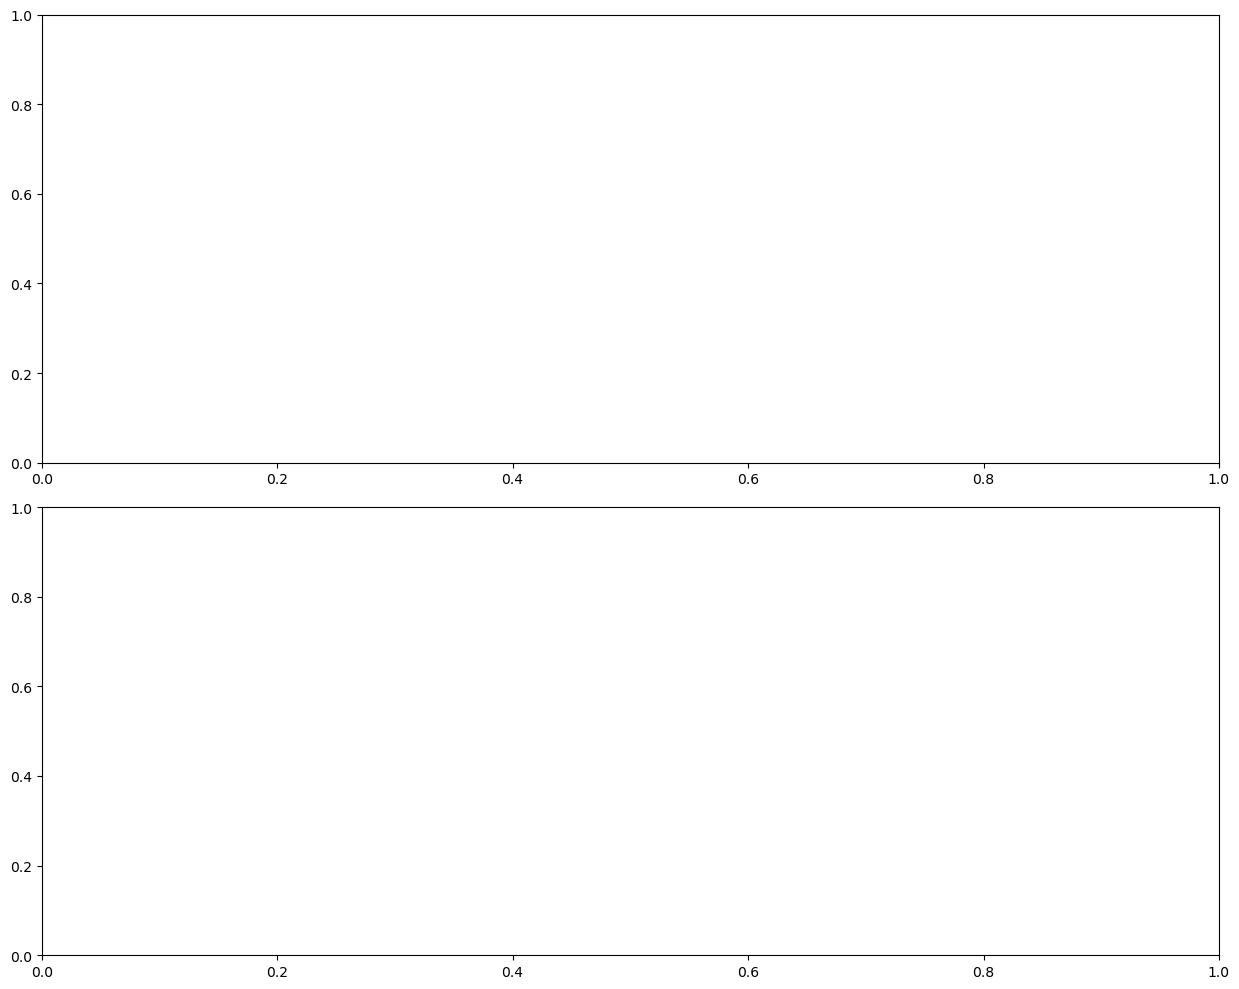

In [34]:
n_epochs = 400

try:
    model.fit(
        # data sequences
        x=crop_seq_train,
        validation_data=crop_seq_val,

        # epochs
        initial_epoch=0,
        epochs=n_epochs,
#         initial_epoch=history_cb.last_epoch + 1,  # for some reason it is 0-starting and others 1-starting...
#         epochs=history_cb.last_epoch + 1 + n_epochs,  
    #     initial_epoch=113,
    #     epochs=126,

        # others
        callbacks=callbacks,  
        verbose=2,
        use_multiprocessing=False,   
    );

except Exception as ex:
    slack.notify_error()
    raise ex
    
else:
    slack.notify_finished()

# History

INFO::tomo2seg::{viz.py:mark_min_values:392}::[2020-12-10::16:19:50.517]
train: argmin=103 --> min=0.0139

INFO::tomo2seg::{viz.py:mark_min_values:392}::[2020-12-10::16:19:50.519]
val: argmin=101 --> min=0.0171



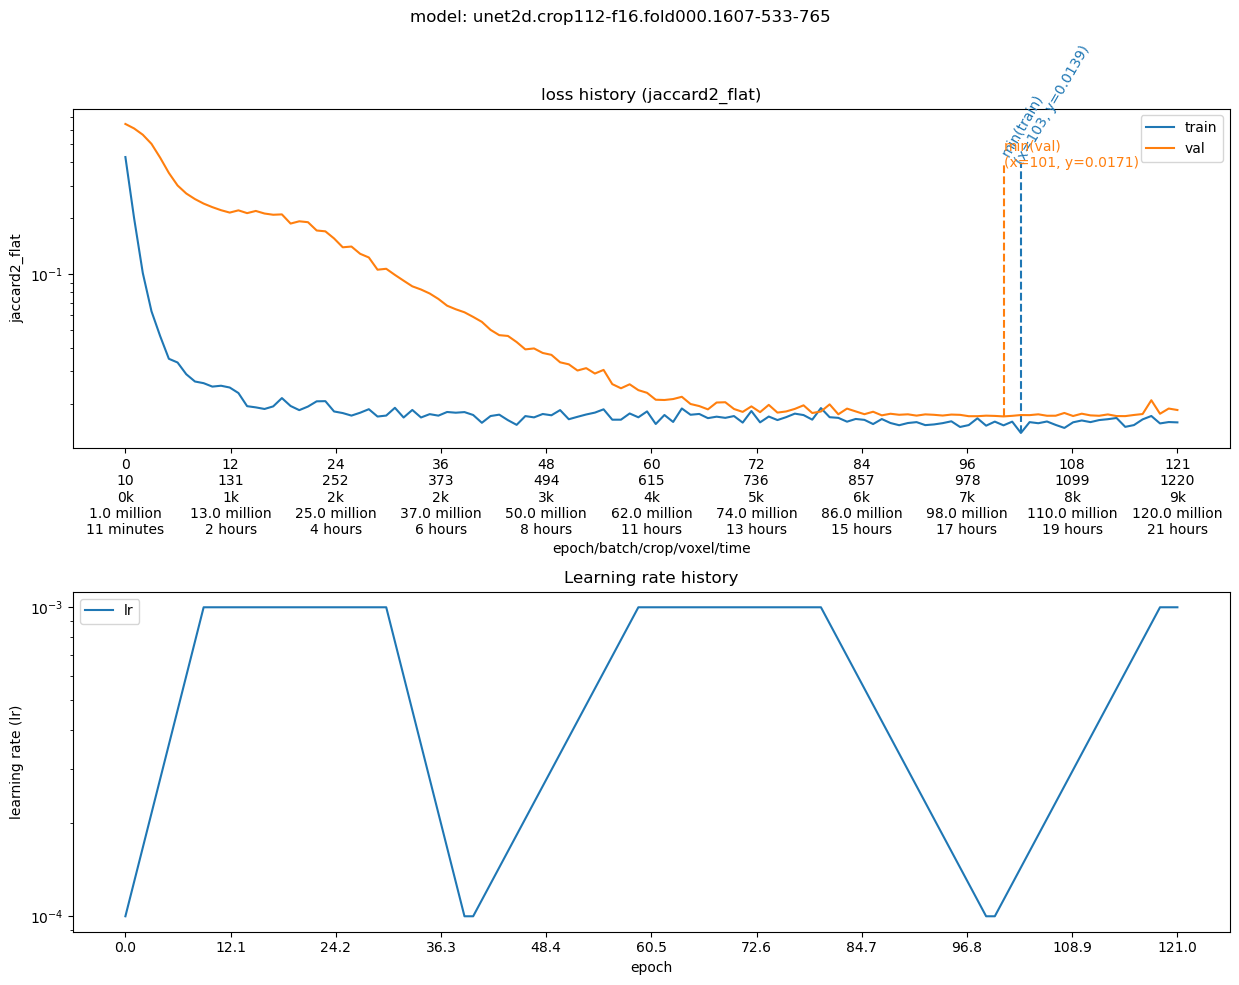

In [35]:
fig, axs = plt.subplots(nrows := 2, ncols := 1, figsize=(2.5 * (sz := 5), nrows * sz), dpi=100)
fig.set_tight_layout(True)

hist_display = viz.TrainingHistoryDisplay(
    history_cb.history, 
    model_name=tomo2seg_model.name,
    loss_name=model.loss.__name__,
    x_axis_mode=(
        "epoch", "batch", "crop", "voxel", "time",
    ),
).plot(
    axs, 
    with_lr=True,
    metrics=(
        "loss", 
    ),
)

axs[0].set_yscale("log")
axs[-1].set_yscale("log")

viz.mark_min_values(hist_display.axs_metrics_[0], hist_display.plots_["loss"][0])
viz.mark_min_values(hist_display.axs_metrics_[0], hist_display.plots_["val_loss"][0], txt_kwargs=dict(rotation=0))

hist_display.fig_.savefig(
    tomo2seg_model.model_path / (hist_display.title + ".png"),
    format='png',
)
# plt.close()

In [36]:
history_cb.dataframe.to_csv(history_cb.csv_path, index=True)

In [37]:
model.save(tomo2seg_model.model_path)

INFO:tensorflow:Assets written to: /home/users/jcasagrande/projects/tomo2seg/data/models/unet2d/unet2d.crop112-f16.fold000.1607-533-765/assets


In [38]:
this_nb_name = "train-04-krilin92.ipynb"
import os
this_dir = os.getcwd()
logger.warning(f"{this_nb_name=} {this_dir=}")

os.system(f"jupyter nbconvert {this_dir}/{this_nb_name} --output-dir {str(tomo2seg_model.model_path)} --to html")

this_nb_name='train-04-krilin92.ipynb' this_dir='/home/users/jcasagrande/projects/tomo2seg/nbs'



0